<a href="https://colab.research.google.com/github/am610/GW_ISIDRO/blob/main/GW_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import windows, butter, filtfilt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
d = pd.read_csv('/content/drive/MyDrive/data_4eos3ye_v3.csv')

print(d.head(3))
print(np.shape(d))
#data = d.drop(columns=['T/W'])

   0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0  ...   792.0.1  \
0 -2.0 -1.99 -1.98 -1.97 -1.96 -1.95 -1.94 -1.93 -1.92 -1.91  ...  8.797552   
1 -2.0 -1.99 -1.98 -1.97 -1.96 -1.95 -1.94 -1.93 -1.92 -1.91  ...  6.434909   
2 -2.0 -1.99 -1.98 -1.97 -1.96 -1.95 -1.94 -1.93 -1.92 -1.91  ...  5.001380   

    793.0.1   794.0.1   795.0.1   796.0.1   797.0.1   798.0.1   799.0.1  \
0  8.661434  8.495477  8.332066  8.164848  7.957539  7.685285  7.366381   
1  7.045128  7.739658  8.482954  9.161344  9.645325  9.882600  9.938364   
2  5.146174  5.381045  5.706619  6.038098  6.283263  6.431564  6.578522   

   Label       T/W  
0   SFHo  0.001529  
1   SFHo  0.003430  
2   SFHo  0.006042  

[3 rows x 1602 columns]
(960, 1602)


## 960 Events

## 1602 columns, first 800 time axis, next 800 GW strain signal, then T/W value column and EoS label column

In [ ]:
set(d.Label)

{'GShenFSU2.1', 'HSDD2', 'LS220', 'SFHo'}

In [ ]:
counts = d.groupby('Label').size()
print(counts)

Label
GShenFSU2.1    240
HSDD2          240
LS220          240
SFHo           240
dtype: int64


Text(0, 0.5, 'T/W')

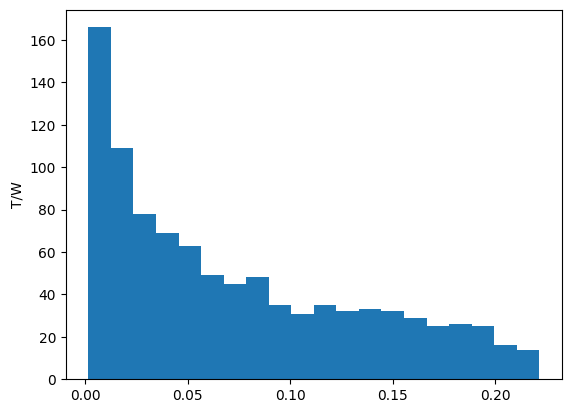

In [ ]:
plt.hist(d['T/W'],bins=20); plt.ylabel('T/W')

In [ ]:

# preprocessing the data :
# Splitting into time and signal
# adding some filters to the data, Tukey and butterworth low pass (it was from the paper)
#

# Load your data
data = d.drop(columns=['T/W'])
df = data #


# Split the DataFrame into time and signal data
midpoint = len(df.columns) // 2
time_data = df.iloc[:, :midpoint]
signal_data = df.iloc[:, midpoint:-1]  # excluding the label column


# Create a Tukey window
alpha = 0.1
window = windows.tukey(M=signal_data.shape[0], alpha=alpha)

# Apply the window to the signal data
windowed_signal_data = signal_data.multiply(window, axis=0)

# Design a low-pass Butterworth filter
order = 10
attenuation = 0.25  # This should be the critical frequency (as a fraction of the Nyquist frequency)
b, a = butter(order, attenuation, btype='low')

# Apply the filter to the windowed signal data
filtered_signal_data = windowed_signal_data.apply(lambda x: filtfilt(b, a, x))

# Combine the time data, filtered signal data, and labels back into a single DataFrame
df_transformed = pd.concat([time_data, filtered_signal_data, df['Label']], axis=1)

#save_path_with_modified_columns = "/content/drive/MyDrive/data_4eos_2_6_Transformed.csv"
#df_transformed.to_csv(save_path_with_modified_columns, index=False)
# One Time Application


### Example Plots

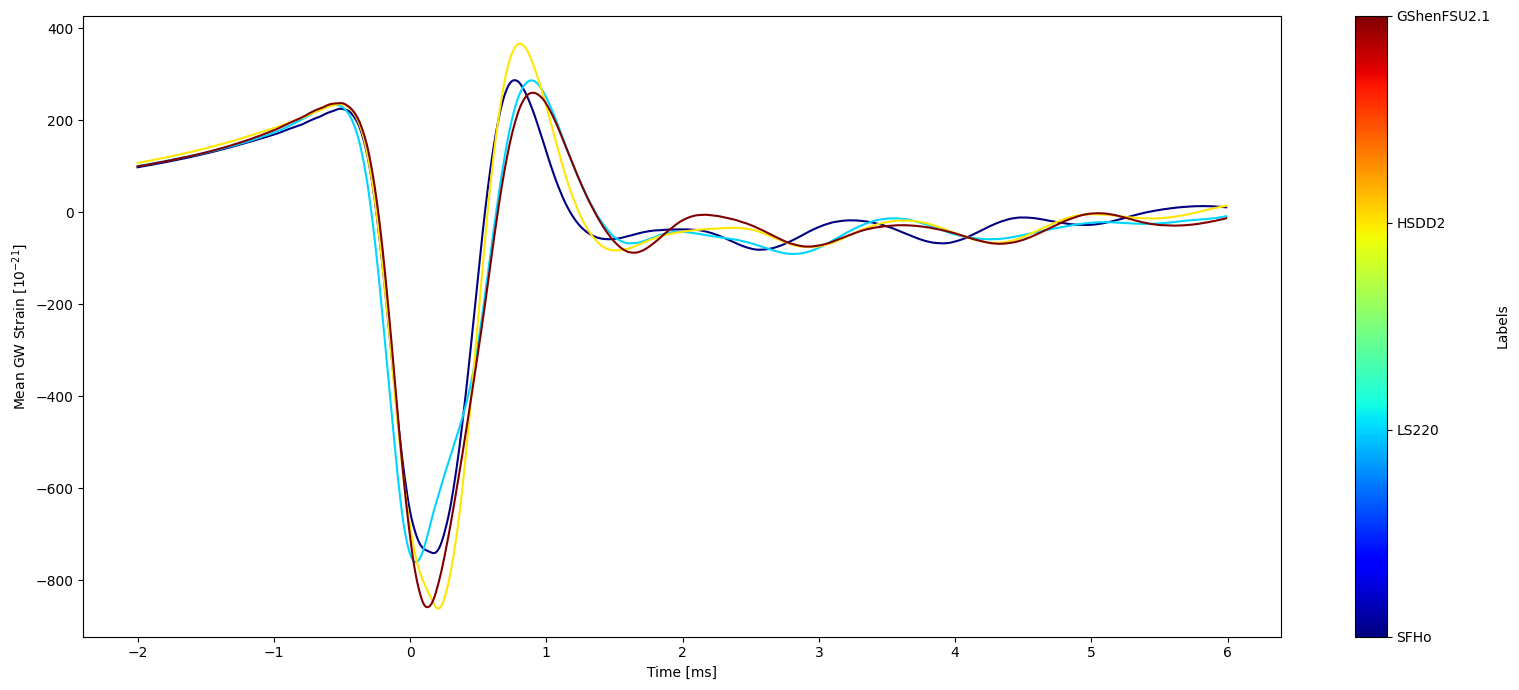

In [ ]:


unique_labels = df_transformed['Label'].unique()
unique_labels

colormap_jet = cm.jet
norm = cm.colors.Normalize(vmin=0, vmax=len(unique_labels)-1)
label_integer_map = {label: index for index, label in enumerate(unique_labels)}

# Split the df_transformed into time, signal, and label parts
half_len = int((df_transformed.shape[1] - 1) / 2)
time_data = df_transformed.iloc[:, :half_len]
signal_data = df_transformed.iloc[:, half_len:-1]
labels = df_transformed['Label']

# Calculate the mean curve for each unique label
mean_curves = signal_data.groupby(labels).mean()

fig, ax = plt.subplots(figsize=(16, 7)) # Create a figure and an axes object

# Use the first row of the time_data as the common time axis
time_values = time_data.iloc[0].values

# Plot the mean curve for each unique label using the jet colormap
for label in unique_labels:
    ax.plot(time_values, mean_curves.loc[label], color=colormap_jet(norm(label_integer_map[label])), label=label) # Plot on the axes object

# Set colorbar with label ticks using the jet colormap
# The `ax` argument tells `colorbar` where to steal space from
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=colormap_jet), ticks=list(label_integer_map.values()), spacing='proportional', ax=ax)
cbar.set_label('Labels')
cbar.set_ticklabels(list(label_integer_map.keys()))

ax.set_xlabel('Time [ms]') # Set labels on the axes object
ax.set_ylabel(r'Mean GW Strain $[10^{-21}]$')
#plt.title('Mean Signals as a function of time with Colorbar (Jet)')
plt.tight_layout()
plt.grid(False)  # Remove grid
plt.tight_layout()